In [58]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
import os
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [59]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

In [87]:
def generate_mobius(feature_indices: List[int], n_additive: int = 2) -> List[Capacity]:
    """
    Generate a random n-additive Möbius measure.
    
    :param feature_indices: List of feature indices (e.g., [0, 1, 2])
    :param n_additive: Maximum size of subsets to include (k-additive)
    :return: List of Capacity objects, where each is Capacity(subset: List[int], value: float)
    """
    m = {frozenset(): 0.0}  # baseline
    
    # Include subsets of size 1 to n_additive
    for k in range(1, n_additive + 1):
        for comb in combinations(feature_indices, k):
            m[frozenset(comb)] = np.random.rand()
    
    # Convert to list of Capacity objects
    tmp = [Capacity(list(k), v) for k, v in m.items()]
    return tmp

def mobius_to_capacity(m: List[Capacity], feature_indices: List[int]) -> List[Capacity]:
    """
    Convert Möbius transform to capacity.
    m: mobius 
    """
    mu = []
    for subset in powerset(feature_indices):
        fs_subset = frozenset(subset)
        total = 0.0
        for B in powerset(subset):
            fs_B = list(frozenset(B))
            tmp = locate_capacity(X=fs_B, capacity=m)
            # print(f"fs_B: {fs_B}, tmp: {tmp}")
            # if fs_B in m:
            total += tmp
        mu.append(Capacity(list(fs_subset), total))

    def norm_capacity(capacity: List[Capacity]) -> List[Capacity]:
        """Normalize the capacity."""
        lst = [c.mu for c in capacity if c.mu is not None]
        min_lst = min(lst)
        max_lst = max(lst)
        # Normalize to [0, 1]
        lst = norm(lst)
        tmp = []
        for i in range(len(lst)):
            tmp.append(Capacity(capacity[i].X, lst[i]))
        return tmp
    return norm_capacity(mu)

In [92]:
features = [0, 1, 2, 3]

mobius = generate_mobius(features, 2)
capacity = mobius_to_capacity(mobius, features)

print("Möbius:")
for i in range(len(mobius)):
    print(f"Mobius of {mobius[i].X} is {mobius[i].mu:.3f}")

print("\nDerived Capacity:")
for c in capacity:
    print(f"Capacity of {c.X} is {c.mu:.3f}")


Möbius:
Mobius of [] is 0.000
Mobius of [0] is 0.008
Mobius of [1] is 0.885
Mobius of [2] is 0.308
Mobius of [3] is 0.471
Mobius of [0, 1] is 0.332
Mobius of [0, 2] is 0.840
Mobius of [0, 3] is 0.640
Mobius of [1, 2] is 0.097
Mobius of [1, 3] is 0.997
Mobius of [2, 3] is 0.646

Derived Capacity:
Capacity of [] is 0.000
Capacity of [0] is 0.001
Capacity of [1] is 0.169
Capacity of [2] is 0.059
Capacity of [3] is 0.090
Capacity of [0, 1] is 0.234
Capacity of [0, 2] is 0.221
Capacity of [0, 3] is 0.214
Capacity of [1, 2] is 0.247
Capacity of [1, 3] is 0.450
Capacity of [2, 3] is 0.273
Capacity of [0, 1, 2] is 0.473
Capacity of [0, 1, 3] is 0.638
Capacity of [0, 2, 3] is 0.558
Capacity of [1, 2, 3] is 0.652
Capacity of [0, 1, 2, 3] is 1.000


In [62]:
for subset in powerset(features):
    print(f"Subset: {set(subset)}")

Subset: set()
Subset: {0}
Subset: {1}
Subset: {2}
Subset: {3}
Subset: {0, 1}
Subset: {0, 2}
Subset: {0, 3}
Subset: {1, 2}
Subset: {1, 3}
Subset: {2, 3}
Subset: {0, 1, 2}
Subset: {0, 1, 3}
Subset: {0, 2, 3}
Subset: {1, 2, 3}
Subset: {0, 1, 2, 3}


In [63]:
X = np.array([0.2, 0.5, 0.8])
choquet_value = Choquet_classic(X, capacity, verbose=True)
print("Choquet integral:", choquet_value)


val_check: [0, 1, 2] - capacity_observation_i: 0.5734637127299701 - val_check2: [1, 2] - capacity_observation_i_1: 0.3352012128308853
val_check: [1, 2] - capacity_observation_i: 0.3352012128308853 - val_check2: [2] - capacity_observation_i_1: 0.12021227521843539
val_check: [2] - capacity_observation_i: 0.12021227521843539 - val_check2: [] - capacity_observation_i_1: 0.0
Choquet integral: 0.25131678896079024


In [64]:
iris_data = load_iris()
iris = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris['target'] = iris_data.target
data, labels = iris.iloc[:, :-1].values, iris.iloc[:, -1].values
data = batch_norm(np.array(data, dtype=np.float32))

In [65]:
choquet = Choquet(X=data[0], mu=capacity, version='classic', p=1, q=1)
print(choquet.choquet)
# choquet.Choquet_classic(verbose=True)

0.6661736219939064


In [66]:
X = data[0]
choquet_value = Choquet_classic(X, capacity, verbose=True)
print("Choquet integral:", choquet_value)


val_check: [3, 2, 1, 0] - capacity_observation_i: 1.0 - val_check2: [2, 1, 0] - capacity_observation_i_1: 0.5734637127299701
val_check: [2, 1, 0] - capacity_observation_i: 0.5734637127299701 - val_check2: [1, 0] - capacity_observation_i_1: 0.24496674346542033
val_check: [1, 0] - capacity_observation_i: 0.24496674346542033 - val_check2: [0] - capacity_observation_i_1: 0.16981425732600364
val_check: [0] - capacity_observation_i: 0.16981425732600364 - val_check2: [] - capacity_observation_i_1: 0.0
Choquet integral: 0.6661736219939064


In [67]:
# Each individual is a dictionary of Möbius values
def mutate(mobius, mutation_rate=0.1):
    new_mobius = mobius.copy()
    for i in range(len(mobius)):
        if np.random.rand() < mutation_rate:
            new_mobius[i] = Capacity(mobius[i].X, np.clip(mobius[i].mu + np.random.uniform(-0.1, 0.1), 0, 1))
    return new_mobius

In [68]:
def crossover(parent1, parent2):
    """Suppose that 2 parents have the same structure with different capacities."""
    child = []
    # Get len parents 
    if len(parent1) != len(parent2):
        raise ValueError("Parents must have the same length")
    len_parents = len(parent1)
    for i in range(len_parents):
        c_1 = parent1[i].mu
        c_2 = parent2[i].mu
        c_c = random.choice([c_1, c_2])
        if c_c == c_1:
            child.append(Capacity(parent1[i].X, c_1))
        else:
            child.append(Capacity(parent2[i].X, c_2))
    return child

In [69]:
cross = crossover(
    parent1=generate_capacity(enumerate_permute_unit(data[0])), 
    parent2=generate_capacity(enumerate_permute_unit(data[0]))
)
print("\nCrossed Capacity:")
for c in cross:
    print(f"Capacity of {c.X} is {c.mu:.3f}")


Crossed Capacity:
Capacity of [] is 0.000
Capacity of [3] is 0.058
Capacity of [2] is 0.118
Capacity of [1] is 0.232
Capacity of [0] is 0.287
Capacity of [3, 2] is 0.413
Capacity of [3, 1] is 0.479
Capacity of [3, 0] is 0.352
Capacity of [2, 1] is 0.624
Capacity of [2, 0] is 0.668
Capacity of [1, 0] is 0.672
Capacity of [3, 2, 1] is 0.811
Capacity of [3, 2, 0] is 0.784
Capacity of [3, 1, 0] is 0.846
Capacity of [2, 1, 0] is 0.882
Capacity of [3, 2, 1, 0] is 1.000


In [72]:
mutated_mobius = mutate(capacity, mutation_rate=0.2)
print("\nMutated Möbius:")
for i in range(len(mutated_mobius)):
    print(f"Mobius of {mutated_mobius[i].X} is {mutated_mobius[i].mu:.3f}")


Mutated Möbius:
Mobius of [] is 0.000
Mobius of [0] is 0.200
Mobius of [1] is 0.052
Mobius of [2] is 0.120
Mobius of [3] is 0.100
Mobius of [0, 1] is 0.245
Mobius of [0, 2] is 0.335
Mobius of [0, 3] is 0.437
Mobius of [1, 2] is 0.279
Mobius of [1, 3] is 0.180
Mobius of [2, 3] is 0.351
Mobius of [0, 1, 2] is 0.671
Mobius of [0, 1, 3] is 0.541
Mobius of [0, 2, 3] is 0.734
Mobius of [1, 2, 3] is 0.594
Mobius of [0, 1, 2, 3] is 1.000


In [73]:
mutated_mu = mutate(capacity, mutation_rate=0.2)
print("\nMutated Möbius:")
for i in range(len(mutated_mu)):
    print(f"Mobius of {mutated_mu[i].X} is {mutated_mu[i].mu:.3f}")


Mutated Möbius:
Mobius of [] is 0.000
Mobius of [0] is 0.087
Mobius of [1] is 0.052
Mobius of [2] is 0.120
Mobius of [3] is 0.100
Mobius of [0, 1] is 0.245
Mobius of [0, 2] is 0.335
Mobius of [0, 3] is 0.437
Mobius of [1, 2] is 0.335
Mobius of [1, 3] is 0.180
Mobius of [2, 3] is 0.351
Mobius of [0, 1, 2] is 0.573
Mobius of [0, 1, 3] is 0.568
Mobius of [0, 2, 3] is 0.799
Mobius of [1, 2, 3] is 0.557
Mobius of [0, 1, 2, 3] is 1.000


Leave one out avec k = 1
SimLevel1: 0.6666666666666666
SimLevel2: 0.3933333333333333
SimLevel3: 0.8733333333333333

Result in 4.6165 seconds.
Leave one out avec k = 2
SimLevel1: 0.6666666666666666
SimLevel2: 0.26666666666666666
SimLevel3: 0.92

Result in 5.2757 seconds.
Leave one out avec k = 3
SimLevel1: 0.6666666666666666
SimLevel2: 0.4
SimLevel3: 0.9333333333333333

Result in 4.7413 seconds.
Leave one out avec k = 4
SimLevel1: 0.6666666666666666
SimLevel2: 0.36
SimLevel3: 0.92

Result in 4.4426 seconds.
Leave one out avec k = 5
SimLevel1: 0.6666666666666666
SimLevel2: 0.48
SimLevel3: 0.94

Result in 4.9256 seconds.
Leave one out avec k = 6
SimLevel1: 0.6666666666666666
SimLevel2: 0.3333333333333333
SimLevel3: 0.9266666666666666

Result in 4.6908 seconds.
Leave one out avec k = 7
SimLevel1: 0.66
SimLevel2: 0.34
SimLevel3: 0.9466666666666667

Result in 4.7815 seconds.
Leave one out avec k = 8
SimLevel1: 0.6666666666666666
SimLevel2: 0.49333333333333335
SimLevel3: 0.9533333333333334

R

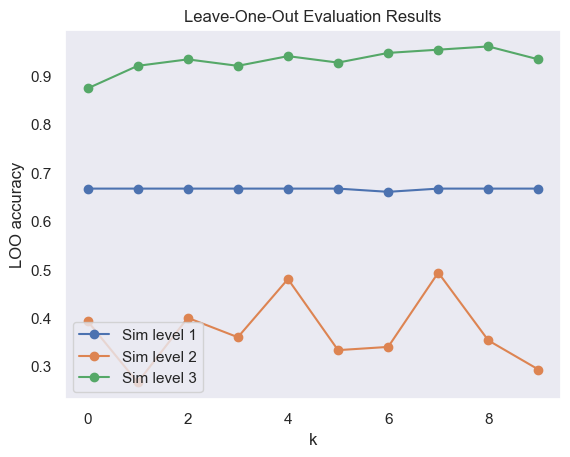

In [75]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mobius = generate_mobius(features)
    mu = mobius_to_capacity(mobius, features)

    print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1], mu=mu, k=3, sim=S1, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l1.append(res)
    print(f"SimLevel1: {res}")
    # Sim level 2
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1],mu=mu, k=k, sim=S2, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l2.append(res)
    print(f"SimLevel2: {res}")

    # Sim level 3
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1],mu=mu, k=k, sim=S3, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l3.append(res)
    print(f"SimLevel3: {res}\n")

    toc = time.time()
    print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results")
plt.grid()
plt.legend()